In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import zipfile
import os
import random
import shutil

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
batch_size = 64
epochs = 100
learning_rate = 1e-5
# patch_size = 4
num_classes = 4
# image_size = 32
channels = 3
# embed_dim = 256
# num_heads = 4
# depth = 8
# mlp_dim = 512
drop_rate = 0.1


In [4]:
image_size = 224
patch_size = 16
embed_dim = 768
depth = 12
num_heads = 16
mlp_dim = 3072

In [5]:
transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5) , (0.5)),
     transforms.Resize((image_size , image_size))
     ]
)

In [6]:
# train_dataset = datasets.ImageFolder(root='/kaggle/input/tumor/Training', transform=transforms)
# test_dataset = datasets.ImageFolder(root='/kaggle/input/tumor/Testing', transform=transforms)

train_dataset = datasets.ImageFolder(root='/kaggle/input/tumor-4/Training', transform=transforms)
test_dataset = datasets.ImageFolder(root='/kaggle/input/tumor-4/Testing', transform=transforms)

In [7]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
import torch
import torch.nn as nn
from torchvision.models.vision_transformer import vit_b_16, ViT_B_16_Weights

class BrainCancerViT(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(BrainCancerViT, self).__init__()

        # Load pretrained ViT-B16
        weights = ViT_B_16_Weights.DEFAULT if pretrained else None
        self.vit = vit_b_16(weights=weights)

        # Extract the embedding dimension (768)
        embed_dim = self.vit.heads.head.in_features

        self.vit.heads.head = nn.Identity()

        self.flatten = nn.Flatten()
        self.bn1 = nn.BatchNorm1d(embed_dim)
        self.fc1 = nn.Linear(embed_dim, 4)
        self.bn2 = nn.BatchNorm1d(11)
        self.fc2 = nn.Linear(11, 4)

    def forward(self, x):
        x = self.flatten(self.vit(x) )           # [768,]
        # x = self.bn1(x)            # [B, 768]
        x = self.fc1(x)            # [B, 11]
        # x = self.bn2(x)            # [B, 11]
        # x = self.fc2(x)            # [B, num_classes]
        return x

# Example Usage
model = BrainCancerViT(embed_dim,
                      num_classes,
                      ).to(device)


In [9]:
print(model)

BrainCancerViT(
  (vit): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): La

In [10]:
loss = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params = model.parameters() , lr = learning_rate)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
def train(model , loader , optimizer , loss_fn):
  model.train()

  total_loss , correct = 0 , 0

  for x , y in loader:
    # print(y.unique())
    x , y = x.to(device) , y.to(device)
    optimizer.zero_grad()
    pred = model(x)
    loss = loss_fn(pred , y)
    loss.backward()
    optimizer.step()

    total_loss = total_loss + loss.item()
    correct = correct + (pred.argmax(1) == y).sum().item()

  total_loss = total_loss / len(loader.dataset)
  correct = correct / len(loader.dataset)

  return total_loss , correct

In [11]:
def evaluate(model , loader , loss_fn):

  model.eval()
  correct = 0
  total_loss = 0

  with torch.inference_mode():
    for x , y in loader:
      x,y = x.to(device) , y.to(device)
      pred = model(x)
      loss = loss_fn(pred , y)
      total_loss = total_loss + loss.item()
      correct = correct + (pred.argmax(1) == y).sum().item()

    correct = correct / len(loader.dataset)
    total_loss = total_loss / len(loader.dataset)
    return total_loss , correct

In [12]:
train_acc_list, test_acc_list = [], []
train_loss_list, test_loss_list = [], []

best_val_acc = 0.0
patience = 10
epochs_no_improve = 0

for epoch in range(epochs):
    print(f'Epoch: {epoch + 1}/{epochs}')
    
    train_loss, train_acc = train(model, train_loader, optimizer, loss)
    test_loss, test_acc = evaluate(model, val_loader, loss)
    
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    
    # Check for improvement
    if test_acc > best_val_acc:
        best_val_acc = test_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), "vit_best_model_multi.pt")  # Save best model weights only
        print(f"✅ New best model saved with val_acc: {test_acc:.4f}")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epochs")

    # Early stopping condition
    if epochs_no_improve >= patience:
        print(f"⏹️ Early stopping triggered at epoch {epoch + 1}")
        break

    print(f'loss: {train_loss:.4f} accuracy: {train_acc:.4f} val_loss: {test_loss:.4f} val_accuracy: {test_acc:.4f}')


Epoch: 1/100
✅ New best model saved with val_acc: 0.8746
loss: 0.0127 accuracy: 0.7112 val_loss: 0.0066 val_accuracy: 0.8746
Epoch: 2/100
✅ New best model saved with val_acc: 0.9181
loss: 0.0047 accuracy: 0.9077 val_loss: 0.0038 val_accuracy: 0.9181
Epoch: 3/100
✅ New best model saved with val_acc: 0.9477
loss: 0.0022 accuracy: 0.9599 val_loss: 0.0024 val_accuracy: 0.9477
Epoch: 4/100
✅ New best model saved with val_acc: 0.9512
loss: 0.0010 accuracy: 0.9869 val_loss: 0.0021 val_accuracy: 0.9512
Epoch: 5/100
No improvement for 1 epochs
loss: 0.0005 accuracy: 0.9983 val_loss: 0.0021 val_accuracy: 0.9495
Epoch: 6/100
✅ New best model saved with val_acc: 0.9564
loss: 0.0002 accuracy: 0.9991 val_loss: 0.0021 val_accuracy: 0.9564
Epoch: 7/100
No improvement for 1 epochs
loss: 0.0001 accuracy: 1.0000 val_loss: 0.0019 val_accuracy: 0.9564
Epoch: 8/100
✅ New best model saved with val_acc: 0.9599
loss: 0.0001 accuracy: 1.0000 val_loss: 0.0019 val_accuracy: 0.9599
Epoch: 9/100
No improvement for 

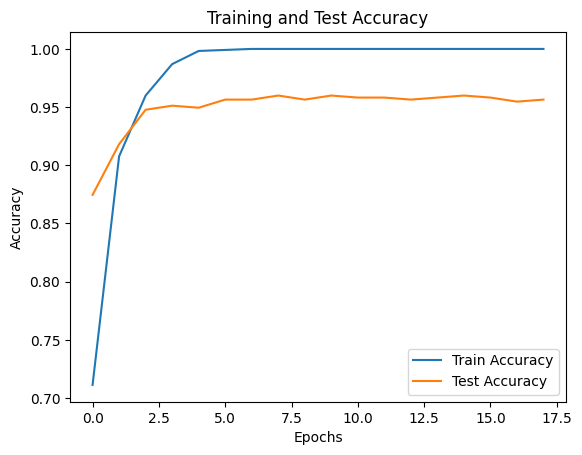

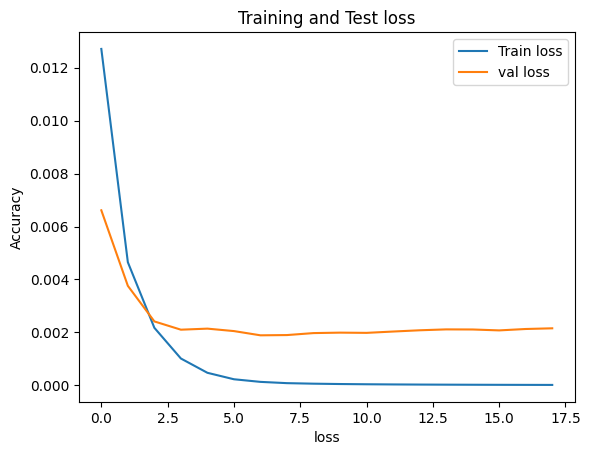

In [13]:
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(test_acc_list, label=" Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Test Accuracy")
plt.savefig('acc_plot_VIT_multi.png')
plt.show()

plt.plot(train_loss_list, label="Train loss")
plt.plot(test_loss_list, label="val loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.title("Training and Test loss")
plt.savefig('loss_plot_VIT_multi.png')
plt.show()

In [14]:
print(evaluate(model , test_loader , loss))

(0.0259012494444242, 0.7309644670050761)


In [15]:
model.load_state_dict(torch.load('/kaggle/working/vit_best_model_multi.pt'))

# 2. Move to device (if using GPU) and set to evaluation mode
model.to(device)
model.eval()

print(evaluate(model, test_loader, loss))

(0.02105628494835142, 0.7309644670050761)


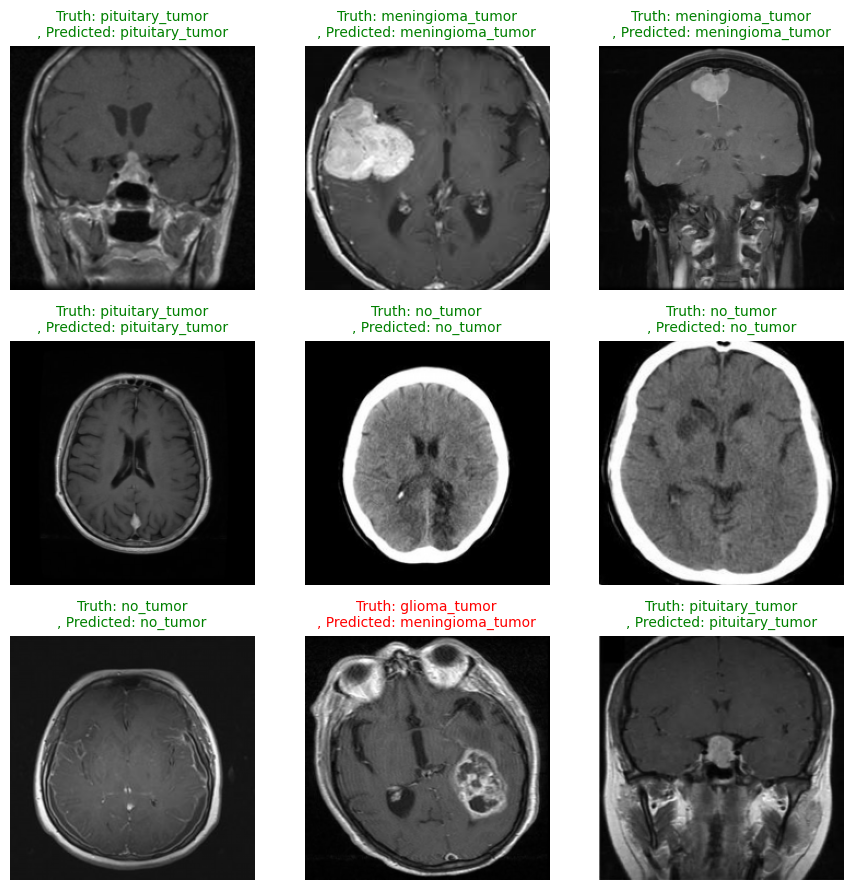

(tensor([3], device='cuda:0'), 3)

In [16]:
test_dataset[0][0].unsqueeze(dim=0).shape
test_dataset[0][0] / 2 + 0.5
def predict_and_plot_grid(model,
                          dataset,
                          classes,
                          grid_size=3):
    model.eval()
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(9, 9))
    for i in range(grid_size):
        for j in range(grid_size):
            idx = random.randint(0, len(dataset) - 1)
            img, true_label = dataset[idx]
            input_tensor = img.unsqueeze(dim=0).to(device)
            predicted = None
            with torch.inference_mode():
                output = model(input_tensor)
                _, predicted = torch.max(output.data, 1)
            img = img / 2 + 0.5 # Unormalize our images to be able to plot them with matplotlib
            npimg = img.cpu().numpy()
            axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
            truth = classes[true_label] == classes[predicted.item()]
            if truth:
                color = "g"
            else:
                color = "r"

            axes[i, j].set_title(f"Truth: {classes[true_label]}\n, Predicted: {classes[predicted.item()]}", fontsize=10, c=color)
            axes[i, j].axis("off")
    plt.tight_layout()
    plt.savefig('preds_visual_multi.png')
    plt.show()

    return predicted , true_label

predict_and_plot_grid(model,
                          test_dataset,
                          classes=['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'],
                          grid_size=3)

<Figure size 1000x500 with 0 Axes>

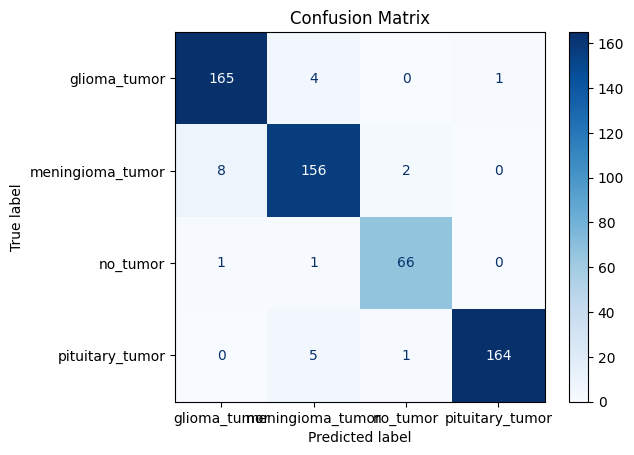

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_cm(model , loader):

  model.eval()
  true = []
  pred = []
  with torch.inference_mode():
    for x , y in loader:
      x,y = x.to(device) , y.to(device)
      preds = model(x)
      preds = torch.argmax(preds, dim=1)
      predictions = preds.cpu().numpy()
      labels = y.cpu().numpy()
      pred.extend(preds.cpu().numpy())   # use extend, not append
      true.extend(y.cpu().numpy())   
    return true , pred

val_loader = torch.utils.data.DataLoader(val_subset, batch_size= 64, shuffle=False)
true , pred = evaluate_cm(model , val_loader)
cm = confusion_matrix(true, pred)
plt.figure(figsize=(10, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.savefig('Vit_multi_confusion_matrix.png')
plt.show()